# Partial BVP

This section provides an example application of the central differences formulae to solve a boundary value problem in variables $x$ and $y$. We will look at the Laplace equation, which is an important and widely studied problem that represents the state-state of the heat equation.

We will tackle the problem using an iterative approach, as this approach is simplest and it tends to be both simple and (reasonably) efficient. However, we will also discuss the approach that solves the system simultaneously.

## Laplace equation

The steady-state version of the two-dimensional heat equation is given by
\begin{equation}
\nabla^2 u=f(x,y), \qquad \nabla^2 = \frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}.
\end{equation}

Applying the second derivative central difference formula at the interior points gives

\begin{equation*}
u_{xx}(x_i,y_j) = \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{h^2},
\end{equation*}

\begin{equation*}
u_{yy}(x_i,y_j) = \frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{h^2},
\end{equation*}

and so we obtain
```{math}
:label: fivept
u_{i+1,j}+u_{i-1,j}+u_{i,j+1}+u_{i,j-1}-4u_{i,j}=h^2 f(x_i,y_j)
```

````{panels}
:card: border-0
The expression on the left in {eq}`fivept` is known as the five-point formula. It can be represented graphically using a stencil, as shown on the right.
---
```{image} images/stencil.png
:alt: secant
:align: center
:scale: 30%
```
````

### Using simultaneous equations

Consider a rectangular plate, with temperature $u(x,y)$ described by the steady heat equation $\nabla^2 u = 0$. The plate is maintained at boundary temperatures $u = 300, 400$ on pairs of opposite edges as shown. We will solve this problem using a central finite difference scheme on a (3 × 3) grid of interior points.

<br>

```{image} images/3_3_grid.png
:alt: 3x3 grid
:scale: 70%
:align: center
```
<br>


There is one equation for each node (equation variable), so we  resulting in the following system of equations :

$$
\begin{bmatrix}
-4 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
1 & -4 & 1 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 1 & -4 & 0 & 0 & 1 & 0 & 0 & 0 \\
1 & 0 & 0 & -4 & 1 & 0 & 1 & 0 & 0 \\
0 & 1 & 0 & 1 & -4 & 1 & 0 & 1 & 0 \\
0 & 0 & 1 & 0 & 1 & -4 & 0 & 0 & 1 \\
0 & 0 & 0 & 1 & 0 & 0 & -4 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 1 & -4 & 1 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & -4
\end{bmatrix}
\begin{bmatrix}
\phi_{11}\\\phi_{12}\\\phi_{13}\\\phi_{21}\\\phi_{22}\\\phi_{23}\\\phi_{31}\\\phi_{32}\\\phi_{33}
\end{bmatrix}
=
\begin{bmatrix}
-700\\-400\\-700\\-300\\0\\-300\\-700\\-400\\-700
\end{bmatrix}
$$

In this example, the values given on the boundary nodes were incorporated on the RHS of the matrix equation. Alternatively, we could solve simultaneously on all 21 illustrated nodes in a similar manner to how we did it in {numref}`dirode`, Equation {eq}`dirmatr1`.

Either way, you may notice that as a consequence of reshaping the array of node values into a column it becomes difficult to keep track of the nodes that are neighbours. This makes the an approach based on simultaneous equations more challenging for multivariable problems.

Additionally, you may observe that the matrix on the left is *sparse*, meaning that most of the elements are zero. This is because the finite difference method only relates each node to its nearest neighbours. Inverting the sparse coefficient matrices can be computationally impractical for problems with many nodes.

Therefore, we will not bother with coding the solution to this problem, and we will instead develop the iterative approach that we saw in the previous chapter.


### Using an iterative approach

Instead of starting with the toy problem given above, we will illustrate for the case where:
\begin{equation}
f(x,y) = 2\cos(\pi y)-\pi^2(1+x)^2\cos(\pi y),
\end{equation}
subject to the conditions
\begin{align*}
u(x,0)&=(1+x)^2, \quad &u(x,1)&=-(1+x)^2,\\
u(0,y)&=\cos(\pi y), \quad &u(1,y)&=4\cos(\pi y).
\end{align*}

We will compare the solution to the analytic result, which is given by
\begin{equation}
u(x,y)=(1+x)^2\cos(\pi y).
\end{equation}

As before, we begin by creating an mesh, this time in two dimensions $(x,y)$ by using meshgrid. We need to obtain $f(x,y)$ at each point on the mesh.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

# This is the RHS of the equation
f = lambda x,y: (2-np.pi**2*(1+x)**2)*np.cos(np.pi*y)

# set up the grid
n=30;
x = np.linspace(0,1,n)
y = np.linspace(0,1,n);

# Useful to store f(x,y) in an array and use F(i,j) instead of f(x(i),y(k))
X,Y = np.meshgrid(x,y)
F=f(X,Y);

# determine grid size
h =x[1]-x[0]

We then initialise the solution matrix at each point on the grid and enforce the boundary conditions:

In [2]:
# to hold the solutions
U = np.zeros((n,n));

# enforce boundary conditions
U[0,:] = (1+x)**2
U[-1,:]=-(1+x)**2
U[:,0] = np.cos(np.pi*y)
U[:,-1]=4*np.cos(np.pi*y)

The final step is to apply the iterative formula, sweeping sequentially through the grid from top-left to bottom right. Here, we use $r=1$, which corresponds to the Gauss-Seidel algorithm, but you could try some higher values for relaxation.

<br>

```{image} images/relax_sweep.png
:alt: secant
:align: center
:scale: 80%
```
<br>

In this implementation, we update only the interior points during the sweep, so the boundary conditions do not need to be re-enforced after each sweep.

In [3]:
r=1;

n,m = np.shape(U)

nsweep=300 #number of sweeps

for k in range(nsweep-1):
    for i in range(1,n-1):
        for j in range(1,m-1):
            Unew = (U[i-1,j]+U[i+1,j]+U[i,j-1]+U[i,j+1])/4-h**2/4*F[i,j]
            U[i,j] = U[i,j]+r*(Unew-U[i,j])

Finally, we compare the results to the analytic solution

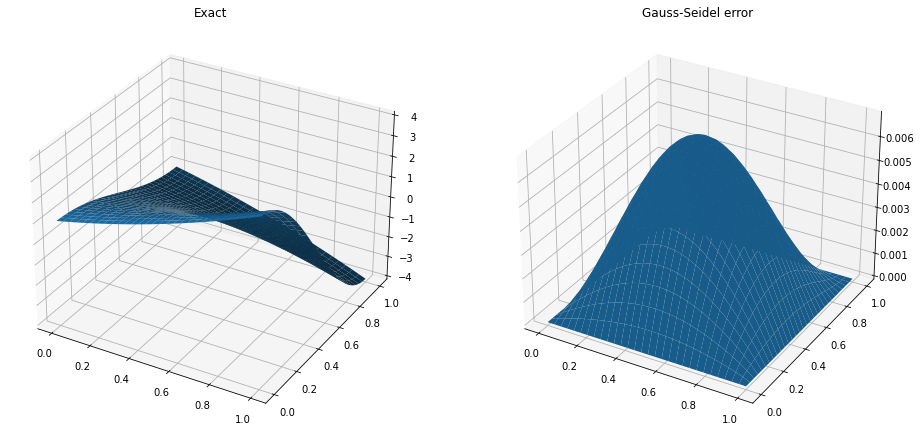

In [4]:
# compare to analytic results
T = (1+X)**2*np.cos(np.pi*Y)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121,projection='3d')
ax1.plot_surface(X,Y,T)
ax1.set_title('Exact')
ax2 = fig.add_subplot(122,projection='3d')
ax2.plot_surface(X,Y,np.abs(U-T))
ax2.set_title('Gauss-Seidel error')
plt.show()

```{exercise}
Solve the problem using an iterative solution technique, for the case where:

\begin{equation*}
f(x,y)=-5 \sin(3\pi x)\cos(2\pi y),
\end{equation*}
subject to the conditions
\begin{equation*}
u_x(0,y)=0, \quad u_x(1,y)=0, \quad u_y(x,0)=0, \quad u_y(x,1)=0.
\end{equation*}

*Hint: to enforce the Neumann boundary conditions, you will need to construct the solution at nodes outside the boundary and remove these ``fictitious'' nodes from your solution at the end.*
```

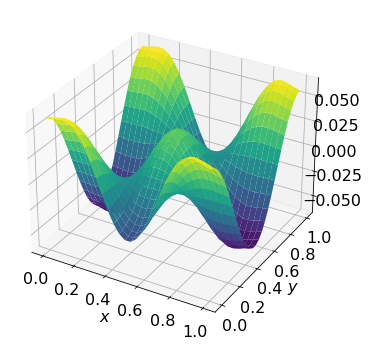

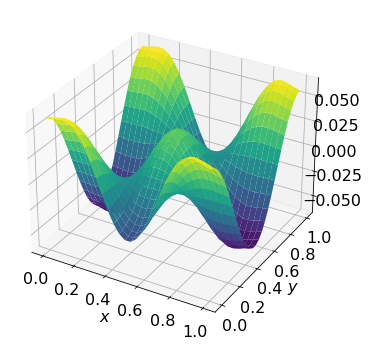

In [5]:
from myst_nb import glue
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

# This is the RHS of the equation
f = lambda x,y: -5*np.sin(3*np.pi*x)*np.cos(2*np.pi*y)

# set up the grid
n=30;
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)

# Useful to store f(x,y) in an array and use F(i,j) instead of f(x(i),y(k))
X,Y = np.meshgrid(x,y)
F=f(X,Y);

# determine grid size
h =x[1]-x[0]

# the solution grid is padded with fictitious nodes to remove at the end
U = np.zeros((n+2,n+2))

# we need to pad F as well, so that the two grids are not mismatched
F=np.pad(F,1, mode='constant');

r=1

n,m = np.shape(U)

nsweep=500 #number of sweeps

for k in range(nsweep-1):
  #enforce boundary conditions on fictitious nodes
  U[0,:]=U[2,:]; U[-1,:]=U[-3,:]
  U[:,0]=U[:,3]; U[:,-1]=U[:,-3]
  for i in range(1,n-1):
    for j in range(1,m-1):
      Unew = (U[i-1,j]+U[i+1,j]+U[i,j-1]+U[i,j+1])/4-h**2/4*F[i,j]
      U[i,j] = U[i,j]+r*(Unew-U[i,j])

sz=16
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111,projection='3d')
ax1.plot_surface(X,Y,U[1:-1,1:-1],cmap='viridis')
ax1.tick_params(labelsize=sz)
ax1.set_xlabel('$x$', fontsize=sz,)
ax1.set_ylabel('$y$', fontsize=sz,)

glue("heatneu_fig", fig, display=False)

````{toggle}

Neumann conditions:

\begin{equation*}
u_x(x,y) = \frac{u(x+h,y)-u(x-h,y)}{2h}, \quad u_y(x,y) = \frac{u(x,y+k)-u(x,y-k)}{2h}
\end{equation*}

Besides changing the definition of the function $f$, we only need to modify the construction of $U$ to include the fictitious nodes. First we initialise the grids including fictitious nodes:

```python
# the solution grid is padded with fictitious nodes to remove at the end
U = np.zeros((n+2,n+2))

# we need to pad F as well, so that the two grids are not mismatched
F=np.pad(F,1, mode='constant')
```

Then, when we perform the update steps we ensure that the boundary conditions are enforced on the fictitious nodes:

```python
for k in range(nsweep-1):
  #enforce boundary conditions on fictitious nodes
  U[0,:]=U[2,:]; U[-1,:]=U[-3,:]
  U[:,0]=U[:,3]; U[:,-1]=U[:,-3]
  for i in range(1,n-1):
    for j in range(1,m-1):
      Unew = (U[i-1,j]+U[i+1,j]+U[i,j-1]+U[i,j+1])/4-h**2/4*F[i,j]
      U[i,j] = U[i,j]+r*(Unew-U[i,j])
```

A plot of `U[1:-1,1:-1]` is shown below. Note that if $\phi_{sol}$ is a solution of this problem, which satisfies the boundary conditions, then $\phi_{sol}+C$ is also a solution. Hence, it is possible for the surface to appear shifted up or down in your answers.

```{glue:} heatneu_fig
```

To further test your understanding, you may wish to try modifying this code so that Neumann conditions on the left and right boundaries are replaced by Dirichlet conditions:

\begin{equation*}
u(0,y)=0, \quad u(1,y)=0, \quad u_y(x,0)=0, \quad u_y(x,1)=0.
\end{equation*}

The exact solution to the problem with these conditions is

\begin{equation*}
U = \frac{5}{13\pi^2}\sin(3\pi x)\cos(2\pi y),
\end{equation*}

which will allow you to check your answer.

````